In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy.io import wavfile
from scipy import signal
import os
from scipy.optimize import curve_fit
import heapq

In [2]:
#For Greek Database
def findMissing(path, start_letter, last_num):
    missing=[]
    directory = os.listdir(path)
    titles = []
    for num in range(1,last_num+1):
        for person in range(1,7):
            if num<10:
                titles.append(start_letter+"0"+str(num)+" ("+str(person)+").wav")
            else: titles.append(start_letter+str(num)+" ("+str(person)+").wav")
    for title in titles:
        if not title in directory:
            missing.append(title)
    return missing

print(findMissing("Happiness", "h", 20))

['h11 (3).wav']


In [73]:
#Equation for combining several Gaussian curves
def Gaussians(x, x0s, sigmas, amplitudes):
    tot = 0
    for i in range(len(x0s)):
        tot+= amplitudes[i]*np.exp(-(x-x0s[i])**2/(4*sigmas[i]**2))
    return tot

In [74]:
#Equation for exactly 3 Gaussian curves; use for best fit
def Gaussians3(x, x01, x02, x03, sigma1, sigma2, sigma3, amplitude1, amplitude2, amplitude3):
    return Gaussians(x,[x01, x02, x03], [sigma1, sigma2, sigma3], [amplitude1, amplitude2, amplitude3])

In [75]:
#Helper function to estimate the standard deviation of a Gaussian within a certain boundary
def findStd(data, freq, bounds):
    weight = data[bounds[0]:bounds[1]]
    av = np.average(freq[bounds[0]:bounds[1]], weights=weight)
    variance = np.average((freq[bounds[0]:bounds[1]]-av)**2, weights=weight)
    return np.sqrt(variance)

In [191]:
def findPeaks(data, freq, num, prom=1):
    '''std = 1
    smoothed = scipy.ndimage.gaussian_filter1d(data, sigma=std, mode="constant")
    peaks, properties = signal.find_peaks(smoothed, prominence=(prom, None))
    counter=0
    
    #prevents there from being too many peaks, will lead to data being too smooth
    while len(peaks)>num*+1:
        std*=1.5
        smoothed = scipy.ndimage.gaussian_filter1d(data, sigma=std, mode="constant")
        peaks, properties = signal.find_peaks(smoothed, prominence=(prom, None))
        counter+=1
        if counter>100:
            print("Maxed out iterations, type 1")
            return None
    counter=0
    
    #counts the top peaks
    while len(peaks)<num:
        prom*=0.8
        peaks, properties = signal.find_peaks(smoothed, prominence=(prom, None))
        counter+=1
        if counter>100:
            print("Maxed out iterations, type 2")
            return None'''
    peaks = signal.find_peaks_cwt(data, np.arange(1,70))
        
    #creates boundaries between peaks for later use
    peak0 = [0, *peaks, peaks[len(peaks)-1]+50]
    if peak0[-1]>len(freq): #prevents index from becoming too big
        peak0[-1] = len(freq)
    bounds = [(max(int((peak0[i]+peaks[i])/2), peaks[i]-150),min(int((peak0[i+2]+peaks[i])/2),peaks[i]+50)) for i in range(len(peaks))]
    
    stds = [findStd(data, freq, bound) for bound in bounds]
    
    #plt.plot(freq, data, color="red", alpha=0.7)
    plt.plot(freq[peaks], data[peaks], "x", color="orange")
    
    return peaks[:num], stds[:num], bounds[:num]

In [137]:
#fitting for Gaussian
def bestFit(freq, data, peaks, smoothed, std, bounds):
    bound1 = bounds[0]
    bound2 = bounds[1]
    bound3 = bounds[2]
    
    boundaryUp = [freq[peaks[1]], freq[peaks[2]], 5e3, 5e2, 5e2, 7e2, max(data[bound1[0]:bound1[1]]), max(data[bound2[0]:bound2[1]]), max(data[bound3[0]:bound3[1]])]
    boundaryDown = [0, freq[int((peaks[0]*2+peaks[1])/3)], freq[int((peaks[1]*2+peaks[2])/3)], 1, 1, 1, 0,0,0]

    starting = [freq[peaks[0]], freq[peaks[1]], freq[peaks[2]], std[0], std[1], std[2], 
                max(data[max(peaks[0]-20,0): min(peaks[0]+20, peaks[len(peaks)-1])])*0.9, 
                max(data[max(peaks[1]-20,0): min(peaks[1]+20, peaks[len(peaks)-1])])*0.9, 
                max(data[max(peaks[2]-20,0): min(peaks[2]+20, peaks[len(peaks)-1])])*0.9]
    for i in range(6):
        if starting[i]>boundaryUp[i]:
            starting = [freq[peaks[0]], freq[peaks[1]], freq[peaks[2]], std[0], std[1], std[2]/2, 
                heapq.nlargest(3,data[bound1[0]:bound1[1]])[2]*0.9, 
                heapq.nlargest(3,data[bound2[0]:bound2[1]])[2]*0.9, 
                heapq.nlargest(3,data[bound3[0]:bound3[1]])[2]*0.9]
            break
    popt, pcov = curve_fit(Gaussians3, smoothed, freq, bounds=(boundaryDown,boundaryUp), p0=starting, method='dogbox')
    return popt, pcov

In [168]:
def PeaksNStd(freq, magnitude):
    peak, std, bound= findPeaks(magnitude, freq,3)
    smoothed = scipy.ndimage.gaussian_filter1d(magnitude, sigma=5)
    try:
        popt, _ = bestFit(freq, magnitude, peak, smoothed, std, bound)
    except ValueError:
        return [*peak[:3], *std[:3], heapq.nlargest(3,magnitude[bound[0][0]:bound[0][1]])[2]*0.9, 
                    heapq.nlargest(3,magnitude[bound[1][0]:bound[1][1]])[2]*0.9, 
                    heapq.nlargest(3,magnitude[bound[2][0]:bound[2][1]])[2]*0.9]
    return popt

In [193]:
test_sample_rate, test_data = wavfile.read("Anger/a01 (3).wav")

In [194]:
f, t, Zxx = signal.stft(test_data, test_sample_rate, nperseg=int(test_sample_rate/5))

In [195]:
index = np.where(f<5000)[0]
index = np.where(f[index]>20)[0]

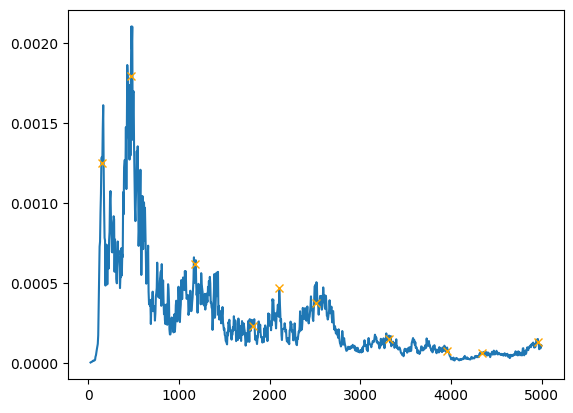

In [196]:
magnitude_median = np.array([np.median(row) for row in np.abs(Zxx)])[index]
plt.plot(f[index], magnitude_median)
param = PeaksNStd(f[index], magnitude_median)

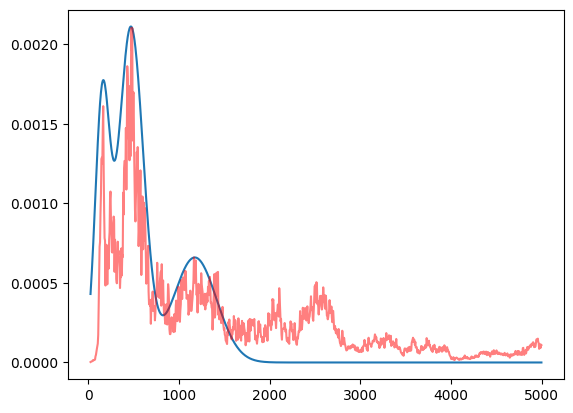

In [197]:
plt.plot(f[index], Gaussians3(f[index], *param))
plt.plot(f[index], magnitude_median, color="red", alpha=0.5)

In [174]:
magnitude_average = np.mean(np.abs(Zxx), axis=1)
magnitude_median = np.array([np.median(row) for row in np.abs(Zxx)])
magnitude_std = [row.std() for row in np.abs(Zxx)]
magnitude_min = np.quantile(np.abs(Zxx), 0.25, axis=1)
magnitude_max = np.quantile(np.abs(Zxx), 0.75, axis=1)

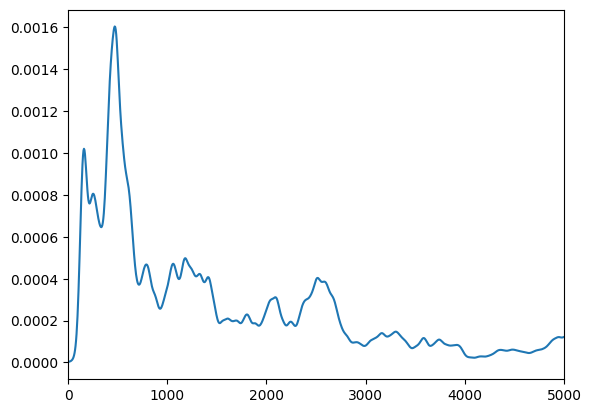

In [175]:
smoothed = scipy.ndimage.gaussian_filter1d(magnitude_median, sigma=5)
plt.xlim([0,5000])
plt.plot(f, smoothed)

In [176]:
average_peaks, properties = signal.find_peaks(smoothed, prominence=(0.0003, None))
print((average_peaks))
print(properties["prominences"].max())

[32 94]
0.0016006014764116117


In [177]:
index = np.where(f<5000)[0]
index = np.where(f[index]>20)[0]
print(magnitude_median.shape)

(4411,)


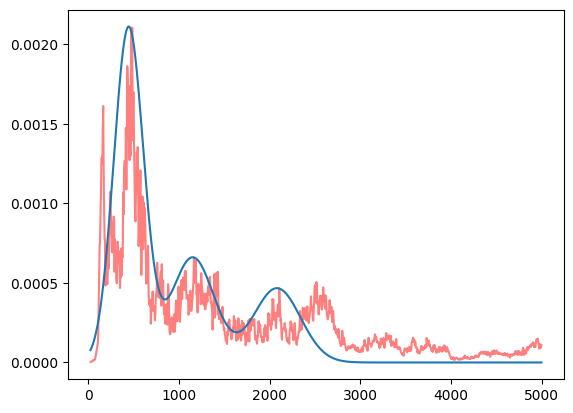

In [179]:
peak, std, bound = findPeaks(magnitude_median[index], f[index],3)
plt.plot(f[index], magnitude_median[index], color="red", alpha=0.5)
plt.plot(f[index], Gaussians(f[index], f[peak], std, [max(magnitude_median[b[0]:b[1]]) for b in bound]))

In [180]:
popt, _ = bestFit(f[index], magnitude_median[index], peak, smoothed, std, bound)
plt.plot(f, Gaussians3(f, *popt))
plt.plot(f, magnitude_median, color="red", alpha=0.5)
plt.xlim([0,5000])

ValueError: operands could not be broadcast together with shapes (4411,) (995,) 